# 1 Dataset and Task
 (a) Select your choice of neural networks model that is suitable for this task and motivate it. Train your model
 to predict one step ahead data point, during training (see following Figure). Scale your data before training
 and scale them back to be able to compare your predictions with real measurements.
 
 (b) How many past time steps should you input into your network to achieve the best possible performance?
 (Hint: This is a tunable parameter and needs to be tuned).
 
 (c) Once your model is trained, use it to predict the next 200 data points recursively. This means feeding each
 prediction back into the model to generate the subsequent predictions.)
 
 (d) On May 9th, download the real test dataset and evaluate your model by reporting both the Mean Absolute
 Error (MAE) and Mean Squared Error (MSE) between its predictions and the actual test values. Additionally,
 create a plot comparing the predicted and real values to visually assess your models performance.

First, we load the data and take a look at it. We also install torch:

Data shape: (1000, 1)
Data type: uint8
Min value: 2
Max value: 255


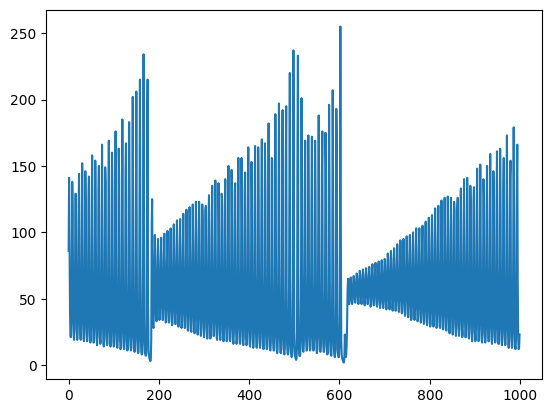

In [1]:
file = 'Xtrain.mat'
# load training data
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Load the training data
data = scipy.io.loadmat(file)
X_train = data['Xtrain']

# Display basic information about the data
print(f"Data shape: {X_train.shape}")
print(f"Data type: {X_train.dtype}")
print(f"Min value: {np.min(X_train)}")
print(f"Max value: {np.max(X_train)}")

# plot the data
plt.plot(X_train)
plt.show()


Now, we scale the data, because then the network works better and faster. 
I also want to scale it back, so that it can get the right outputs.

In [2]:
import sklearn
from sklearn.preprocessing import StandardScaler

#let's scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train.reshape(-1, 1))

#We also want the scaled back data ready:
restored_data = scaler.inverse_transform(scaled_data)

# Printing the first few values of the scaled and restored data to check
print(f"First few scaled values:\n{scaled_data[:5]}")
print(f"First few restored values:\n{restored_data[:5]}")

#Display basic information about the data
print(f"Data shape: {scaled_data.shape}")
print(f"Data type: {scaled_data.dtype}")
print(f"Min value: {np.min(scaled_data)}")
print(f"Max value: {np.max(scaled_data)}")

First few scaled values:
[[ 0.55720154]
 [ 1.73111118]
 [ 0.74929585]
 [-0.40326998]
 [-0.8088024 ]]
First few restored values:
[[ 86.]
 [141.]
 [ 95.]
 [ 41.]
 [ 22.]]
Data shape: (1000, 1)
Data type: float64
Min value: -1.2356786270219065
Max value: 4.16430570013708


In [8]:
#Now we want to split the data so that we have training, validation, and test data:
train_ratio = 0.8
val_ratio = 1-train_ratio

train_split_point = int(len(scaled_data) * train_ratio)
val_split_point = train_split_point + int(len(scaled_data) * val_ratio)

train_data = scaled_data[:train_split_point]
val_data = scaled_data[train_split_point:val_split_point]
test_data = scaled_data[val_split_point:]

print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

#making tensors:
#tensor_of_data = torch.tensor(train_data)
#print(f"`Tensor of the data` is a {tensor_of_data.ndim}-d Tensor with shape: {tensor_of_data.shape}")
#Now we define the function that retrieves the sequences:
def create_sequences(data, seq_len):
    sequences = []
    labels = []
    for i in range(len(data) - seq_len):
        seq = data[i:i+seq_len]
        label = data[i+seq_len]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)
seq_len = 15
X_train_seq, y_train = create_sequences(train_data, seq_len)
X_val_seq, y_val = create_sequences(val_data, seq_len)
X_test_seq, y_test = create_sequences(test_data, seq_len)

# Convert to PyTorch tensors
X_train_seq = torch.tensor(X_train_seq, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val_seq = torch.tensor(X_val_seq, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test_seq = torch.tensor(X_test_seq, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_dataset = TensorDataset(X_train_seq, y_train)
val_dataset = TensorDataset(X_val_seq, y_val)
test_dataset = TensorDataset(X_test_seq, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Training data shape: (689, 15, 1)
Validation data shape: (147, 15, 1)
Test data shape: (149, 15, 1)


In [5]:
#making the LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # use output from last time step
        out = self.fc(out)
        return out

/Users/alexamirejibi/miniconda3/envs/laser/lib/python3.13/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/70 - Train Loss: 1.0459 - Val Loss: 0.8686 (Best Model Saved)
Epoch 2/70 - Train Loss: 1.0087 - Val Loss: 0.8159 (Best Model Saved)
Epoch 3/70 - Train Loss: 0.9315 - Val Loss: 0.7199 (Best Model Saved)
Epoch 4/70 - Train Loss: 0.7497 - Val Loss: 0.4716 (Best Model Saved)
Epoch 5/70 - Train Loss: 0.3722 - Val Loss: 0.3507 (Best Model Saved)
Epoch 6/70 - Train Loss: 0.2577 - Val Loss: 0.2258 (Best Model Saved)
Epoch 7/70 - Train Loss: 0.2155 - Val Loss: 0.2006 (Best Model Saved)
Epoch 8/70 - Train Loss: 0.1801 - Val Loss: 0.2010
Epoch 9/70 - Train Loss: 0.1676 - Val Loss: 0.1667 (Best Model Saved)
Epoch 10/70 - Train Loss: 0.1548 - Val Loss: 0.1396 (Best Model Saved)
Epoch 11/70 - Train Loss: 0.1405 - Val Loss: 0.1291 (Best Model Saved)
Epoch 12/70 - Train Loss: 0.1259 - Val Loss: 0.1332
Epoch 13/70 - Train Loss: 0.1185 - Val Loss: 0.1112 (Best Model Saved)
Epoch 14/70 - Train Loss: 0.1051 - Val Loss: 0.0957 (Best Model Saved)
Epoch 15/70 - Train Loss: 0.0946 - Val Loss: 0.0851 (

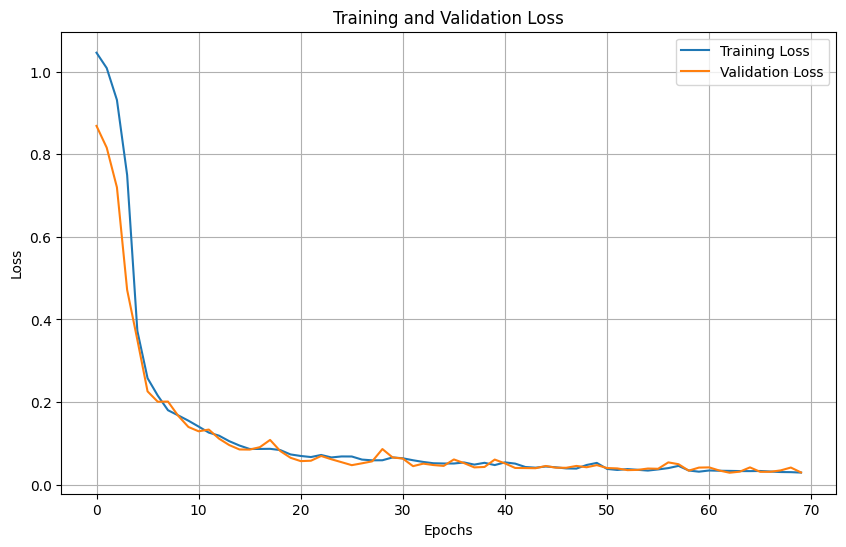

AttributeError: 'tuple' object has no attribute 'copy'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(hidden_size=64, num_layers=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#training loop
num_epochs = 70
train_losses, val_losses = [], []
best_val_loss = float('inf')
best_model_state = None
for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.squeeze(), y_batch.squeeze())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch.squeeze())
            val_loss += loss.item()
    
    # record losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    best_epoch = -1
    
    # save the best model
    if val_loss < best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} (Best Model Saved)")
    else:
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

# load best model
model.load_state_dict(best_model_state)
print(f"Best validation loss: {best_val_loss:.4f} for epoch {best_epoch}")

## plot losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


#auto-regressive prediction for the next 200 data points
model.eval()

actual_seq_len_for_data = seq_len
num_recursive_predictions = 200
autoregressive_predictions_scaled_list = []

# Initialize the current sequence from the beginning of test_data
current_sequence_scaled_np = test_data[:actual_seq_len_for_data].copy() # Shape: (actual_seq_len_for_data, 1)
# Reshape for the model: (batch_size, seq_len, input_features)
current_sequence_tensor = torch.tensor(current_sequence_scaled_np, dtype=torch.float32).view(1, actual_seq_len_for_data, 1).to(device)

# Perform auto-regressive prediction
for _ in range(num_recursive_predictions):
    with torch.no_grad():
        # Get the model's prediction for the next time step
        next_prediction_scaled_tensor = model(current_sequence_tensor) # Output shape: (1, 1)
    
    # Store the prediction (scalar value)
    autoregressive_predictions_scaled_list.append(next_prediction_scaled_tensor.item())
    
    # Update the sequence for the next prediction:
    # Remove the oldest element and append the new prediction
    # Ensure the new prediction tensor has the shape (1, 1, 1) for concatenation
    new_element_tensor = next_prediction_scaled_tensor.view(1, 1, 1)
    current_sequence_tensor = torch.cat((current_sequence_tensor[:, 1:, :], new_element_tensor), dim=1)

autoregressive_predictions_scaled_np = np.array(autoregressive_predictions_scaled_list).reshape(-1, 1)

# --- Evaluation ---
# Determine how many actual values are available for comparison
start_index_for_actuals_comparison = actual_seq_len_for_data
num_actuals_available_for_comparison = len(test_data) - start_index_for_actuals_comparison

num_points_to_compare = min(num_recursive_predictions, max(0, num_actuals_available_for_comparison))

if num_points_to_compare < num_recursive_predictions:
    print(f"Warning: Generated {num_recursive_predictions} predictions, but only able to compare with {num_points_to_compare} actual future data points from the test set.")

# slice the predictions and actuals to the comparable length
predictions_to_compare_scaled = autoregressive_predictions_scaled_np[:num_points_to_compare]
actuals_for_comparison_scaled = test_data[start_index_for_actuals_comparison : start_index_for_actuals_comparison + num_points_to_compare].reshape(-1, 1)

# inverse transform to original scale for reporting and plotting
predictions_original_scale = scaler.inverse_transform(predictions_to_compare_scaled)
actuals_original_scale = scaler.inverse_transform(actuals_for_comparison_scaled)

# calculate MAE and MSE on original scale values
mae = np.mean(np.abs(predictions_original_scale - actuals_original_scale))
mse = np.mean((predictions_original_scale - actuals_original_scale)**2)

print(f"\nAuto-regressive Evaluation ({num_points_to_compare} steps):")
print(f"  Mean Absolute Error (MAE) on Original Scale: {mae:.4f}")
print(f"  Mean Squared Error (MSE) on Original Scale: {mse:.4f}")

# Visualize predictions vs actual values (original scale)
plt.figure(figsize=(12, 6))
plt.plot(actuals_original_scale, label='Actual Values (Original Scale)', alpha=0.9)
plt.plot(predictions_original_scale, label=f'Auto-regressive Predictions ({num_points_to_compare} steps, Original Scale)', alpha=0.7, linestyle='--')
plt.xlabel(f'Time Step (after initial {actual_seq_len_for_data}-step sequence)')
plt.ylabel('Value (Original Scale)')
plt.title(f'Auto-regressive Model Predictions vs Actual Values ({num_points_to_compare} steps)')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot of predicted vs actual (original scale)
plt.figure(figsize=(8, 8))
min_val = min(np.min(actuals_original_scale), np.min(predictions_original_scale))
max_val = max(np.max(actuals_original_scale), np.max(predictions_original_scale))
plt.scatter(actuals_original_scale, predictions_original_scale, alpha=0.5)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction Line')
plt.xlabel('Actual Values (Original Scale)')
plt.ylabel('Predicted Values (Original Scale)')
plt.title(f'Auto-regressive Predicted vs Actual ({num_points_to_compare} steps)')
plt.legend()
plt.grid(True)
plt.axis('equal') # Ensure a square plot for better visualization of the diagonal
plt.show()